<a href="https://colab.research.google.com/github/kshashank03/data-science-projects/blob/master/Regression_Models/metro_interstate_traffic_regression_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic Data Regression Project - Shashank Kalanithi

### Using a traffic volume dataset from the UCI Machine Learning repository, we're going to see if we can predict traffic patterns using regression models.


In [0]:
### Dataset Origin ###
#https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume 

### Package Installs, Dataset Import, and Inspection ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 0) 

dataset = pd.read_csv('/content/drive/My Drive/Data Science/Metro Interstate Traffic/Metro_Interstate_Traffic_Volume.csv', parse_dates=[7])

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Variable Descriptions

- **holiday**: *Categorical* US National holidays plus regional holiday, Minnesota State Fair

- **temp**: *Numeric* Average temp in kelvin

- **rain_1h**: *Numeric* Amount in mm of rain that occurred in the hour

- **snow_1h**: *Numeric* Amount in mm of snow that occurred in the hour

- **clouds_all**: *Numeric* Percentage of cloud cover

- **weather_main**: *Categorical* Short textual description of the current weather

- **weather_description**: *Categorical* Longer textual description of the current weather

- **date_time**: *DateTime* Hour of the data collected in local CST time

- **traffic_volume**: *Numeric* Hourly I-94 ATR 301 reported westbound traffic volume

# Dataset Cleansing, Train-Test Split, Encoding, and Scaling

We'll need to check and see if any categorical values need to be cleansed and check for patterns of distribution in our numeric and datetime values. 


In [27]:
### Check for missing data ###

if len(dataset.dropna()) == len(dataset):
    print("No missing values")
else:
    print("Missing values")

No missing values


In [28]:
### Summary Statistics ###

dataset.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


## Summary Statistics Discoveries
It looks like we have some potential junk values. A temperature of 0 degrees kelvin sounds impossible (min value for temp). Also 9831mm of rain or over 9m of rain sounds impossible for one hour of rain in Minnesota (max rain_1h value).

### Cleaning Temperature
We're going to get rid of any temperature values under -60F (222K) as that's the coldest temperature ever recorded in Minnesota
https://weather.com/news/climate/news/coldest-temperature-recorded-50-states 

### Cleaning Rain
We're going to get rid of any rain values that are above 15.1in (383.54mm) as this is the most rain that fallen in a 24 hour period in Minnesota.
https://en.wikipedia.org/wiki/List_of_Minnesota_weather_records 


In [29]:
### Cleaning Temperature ###

dataset_clean1 = dataset.loc[dataset['temp']>=222]

### Cleaning Rain ###

dataset_clean2 = dataset_clean1.loc[dataset_clean1['rain_1h']<=383]
dataset_clean2.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48193.000000,48193.000000,48193.000000,48193.000000,48193.000000
mean,281.263786,0.130342,0.000222,49.371942,3260.174029
std,12.709364,1.003480,0.008169,39.013548,1986.754010
min,243.390000,0.000000,0.000000,0.000000,0.000000
25%,272.180000,0.000000,0.000000,1.000000,1194.000000
50%,282.460000,0.000000,0.000000,64.000000,3380.000000
75%,291.810000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,55.630000,0.510000,100.000000,7280.000000


### Parsing out Date Parts from Datetime column

There might be seasonal or day-based shifts in usage, so we are going to parse out all of the relavent date parts from the DateTime column.

In [0]:
### Parsing Out Year, Month, and Time from DateTime ###

dataset_clean2['date_time_year'] = pd.DatetimeIndex(dataset_clean2['date_time']).year
dataset_clean2['date_time_month'] = pd.DatetimeIndex(dataset_clean2['date_time']).month
dataset_clean2['date_time_time'] = pd.DatetimeIndex(dataset_clean2['date_time']).time
dataset_clean2['date_time_year'] = dataset_clean2['date_time_year'].apply(lambda x: int(x))
dataset_clean2['date_time_month'] = dataset_clean2['date_time_month'].apply(lambda x: int(x))
dataset_clean2['date_time_time'] = dataset_clean2['date_time_time'].apply(lambda x: x.hour * 3600)

## Visualization (Plotted dataset was halved to fit in Github)

Visualization is an important part of the analytic process and will help us see patterns that might be hidden from the summary statistics

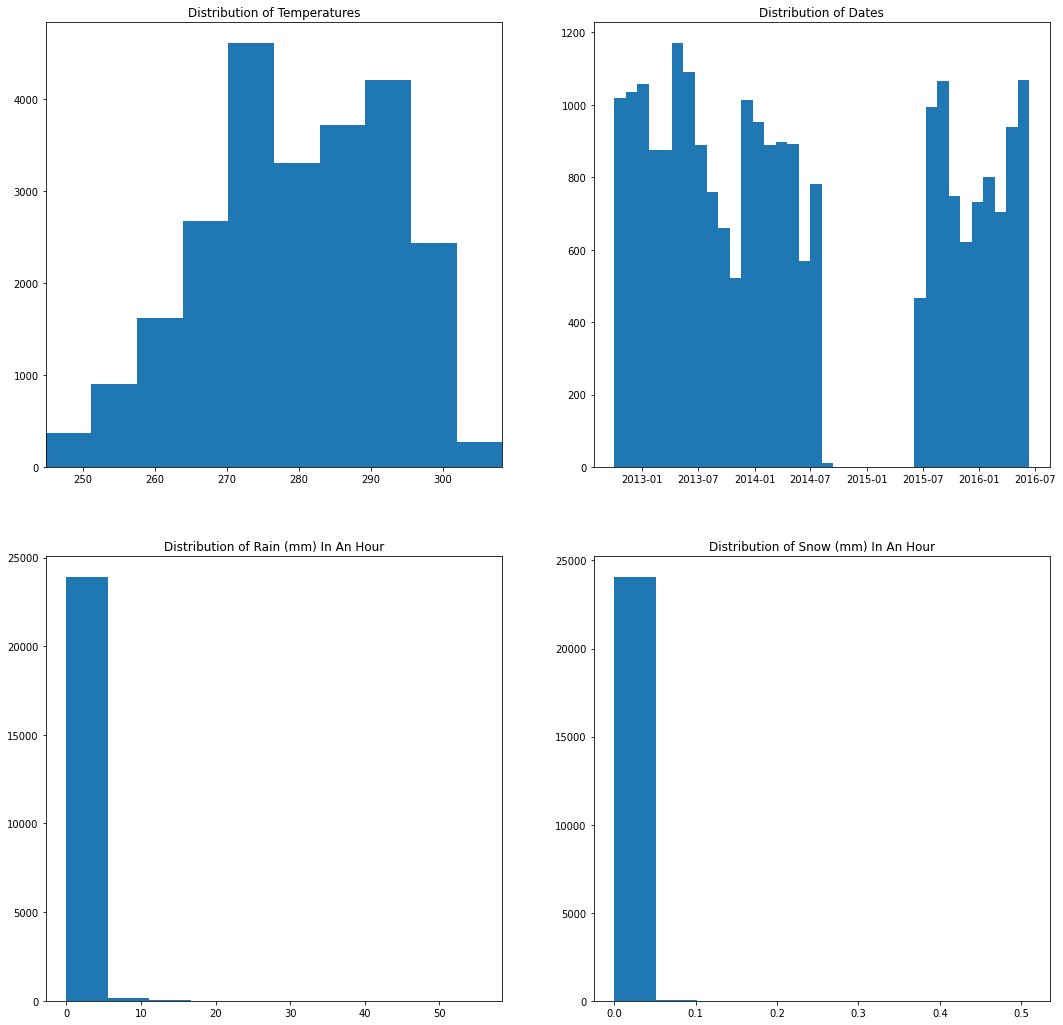

In [42]:
dataset_shrunk = dataset_clean2.iloc[: round(len(dataset_clean2)/2) , :]

plt.figure(figsize=(18, 18))


plt.subplot(2, 2, 1)
plt.xlim(min(dataset_shrunk['temp']), max(dataset_shrunk['temp']))
plt.hist(dataset_shrunk['temp'])
plt.title("Distribution of Temperatures")



### Explore the ['date_time'] field ###

plt.subplot(2, 2, 2)
#dataset_clean2['date_time_convert'] =  pd.to_datetime(dataset_clean2['date_time'])
plt.hist(dataset_shrunk['date_time'], bins=(len(pd.to_datetime(dataset_shrunk['date_time']).dt.to_period('M').groupby(pd.to_datetime(dataset_shrunk['date_time']).dt.to_period('M')).count()))) # Creates bins at the month level 
plt.title("Distribution of Dates")


### Explore the rain data ###

plt.subplot(2, 2, 3)
plt.hist(dataset_shrunk['rain_1h'])
plt.title("Distribution of Rain (mm) In An Hour")


### Explore the snow data ###

plt.subplot(2, 2, 4)
plt.hist(dataset_shrunk['snow_1h'])
plt.title("Distribution of Snow (mm) In An Hour")

plt.show()

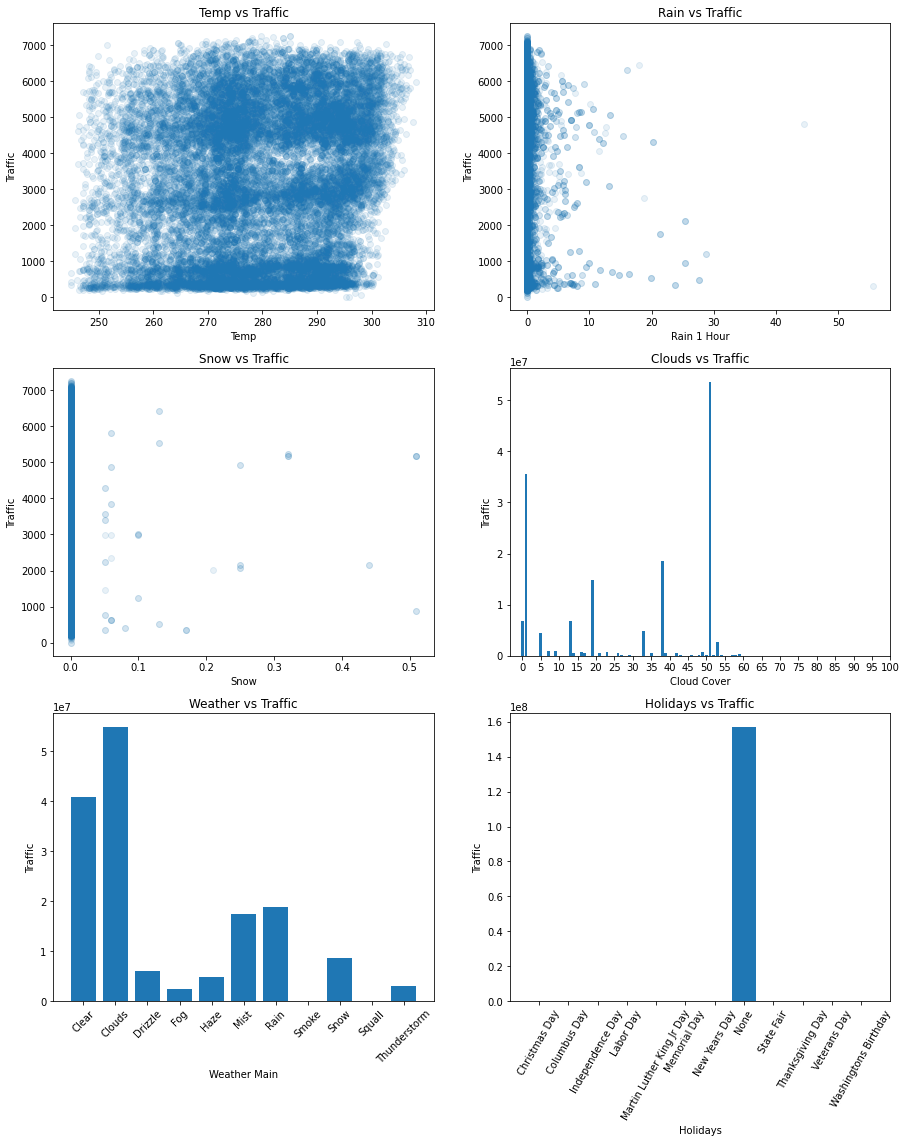

In [50]:
holiday_data = dataset_clean2.groupby('holiday').traffic_volume.sum().reset_index()
weather_data = dataset_clean2.groupby('weather_main').traffic_volume.sum().reset_index()
cloud_data = dataset_clean2.groupby('clouds_all').traffic_volume.sum().reset_index()

plt.figure(figsize=(15, 18))

plt.subplot(3, 2, 1)
plt.scatter(dataset_shrunk['temp'], dataset_shrunk['traffic_volume'], alpha=0.1)
plt.title('Temp vs Traffic')
plt.xlabel('Temp')
plt.ylabel('Traffic')

plt.subplot(3, 2, 2)
plt.scatter(dataset_shrunk['rain_1h'], dataset_shrunk['traffic_volume'], alpha=0.1)
plt.title('Rain vs Traffic')
plt.xlabel('Rain 1 Hour')
plt.ylabel('Traffic')

plt.subplot(3, 2, 3)
plt.scatter(dataset_shrunk['snow_1h'], dataset_shrunk['traffic_volume'], alpha=0.1)
plt.title('Snow vs Traffic')
plt.xlabel('Snow')
plt.ylabel('Traffic')

plt.subplot(3, 2, 4)
plt.bar(range(len(cloud_data)), cloud_data['traffic_volume'])
plt.title('Clouds vs Traffic')
plt.xlabel('Cloud Cover')
plt.ylabel('Traffic')
plt.subplot(3, 2, 4).set_xticks([i*5 for i in range(21)])

plt.subplot(3, 2, 5)
plt.bar(range(len(weather_data)), weather_data['traffic_volume'])
plt.title('Weather vs Traffic')
plt.xlabel('Weather Main')
plt.ylabel('Traffic')
plt.subplot(3, 2, 5).set_xticks(range(len(weather_data)))
plt.subplot(3, 2, 5).set_xticklabels(weather_data['weather_main'])
plt.xticks(rotation=45)

plt.subplot(3, 2, 6)
plt.bar(range(len(holiday_data)), holiday_data['traffic_volume'])
plt.title('Holidays vs Traffic')
plt.xlabel('Holidays')
plt.ylabel('Traffic')
plt.subplot(3, 2, 6).set_xticks(range(len(holiday_data)))
plt.subplot(3, 2, 6).set_xticklabels(holiday_data['holiday'])
plt.xticks(rotation=60)

plt.show()

## Encoding Variables and Train Test Split

In [0]:
x = dataset_clean2.loc[:, ['holiday', 'weather_main', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'date_time_year', 'date_time_month', 'date_time_time']].values
y = dataset_clean2.loc[:, ['traffic_volume']].values

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0, 1])], remainder='passthrough') 

x_encoded = np.array(ct.fit_transform(x)) 

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=0)

## Feature Scaling For Models that Require It



In [0]:
from sklearn.preprocessing import StandardScaler
scx = StandardScaler()
scy = StandardScaler()

x_train_scaled = x_train
x_test_scaled = x_test

#Don't scale dummy variables
x_train_scaled[:, 23:] = scx.fit_transform(x_train[:, 23:])
#We need to make sure we use the same scalar from the train set to the test set
x_test_scaled[:, 23:] = scx.transform(x_test[:, 23:])

y_train_scaled = scy.fit_transform(y_train)
y_test_scaled = scy.transform(y_test)

# Machine Learning Models

## Multiple Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression

regressor_lin = LinearRegression()
regressor_lin.fit(x_train, y_train)

y_lin_pred = regressor_lin.predict(x_test)

## Support Vector Machine Regression

In [0]:
from sklearn.svm import SVR
regressor_svr = SVR(kernel='rbf')
regressor_svr.fit(x_train_scaled, y_train_scaled)
y_svr_pred = regressor_svr.predict(x_test_scaled)

## Decision Tree Regressor

In [0]:
from sklearn.tree import DecisionTreeRegressor

regression_tree = DecisionTreeRegressor(random_state=0)

regression_tree.fit(x_train, y_train)

y_dectree_pred = regression_tree.predict(x_test)


## Random Forest Regressor

In [0]:
from sklearn.ensemble import RandomForestRegressor

rndm_frst = RandomForestRegressor(n_estimators=10, random_state=0)

rndm_frst.fit(x_train, y_train)

y_rndmfrst_pred = rndm_frst.predict(x_test)

## Results

In [39]:
from sklearn.metrics import r2_score
results_dictionary = {'Model':['Multi Linear Regression', 'SVR', 'Decision Tree', 'Random Forest'], 'R2': [r2_score(y_test, y_lin_pred), r2_score(y_test_scaled, y_svr_pred), r2_score(y_test, y_dectree_pred), r2_score(y_test, y_rndmfrst_pred)]}

results_df = pd.DataFrame(results_dictionary)
results_df

,Model,R2
0,Multi Linear Regression,0.139270
1,SVR,0.651831
2,Decision Tree,0.670141
3,Random Forest,0.790482


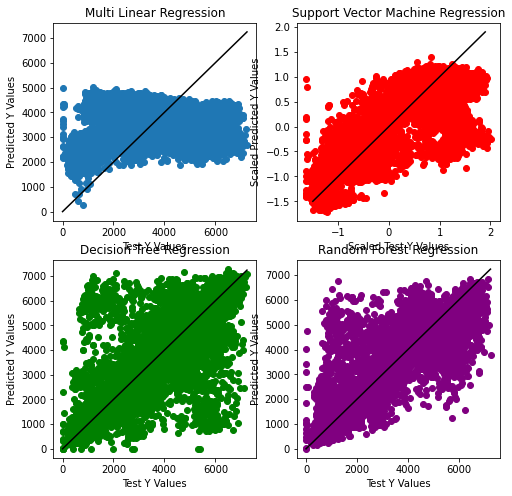

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_lin_pred)
plt.plot(np.arange(0, max(y_test), 1), color='black')
plt.xlabel('Test Y Values')
plt.ylabel('Predicted Y Values')
plt.title("Multi Linear Regression")

plt.subplot(2, 2, 2)
plt.scatter(y_test_scaled, y_svr_pred, color='red')
plt.plot(np.arange(-1.5, 2.0, 0.1), np.arange(-1.5, 2.0, 0.1), color='black')
plt.xlabel('Scaled Test Y Values')
plt.ylabel('Scaled Predicted Y Values')
plt.title("Support Vector Machine Regression")

plt.subplot(2, 2, 3)
plt.scatter(y_test, y_dectree_pred, color='green')
plt.plot(np.arange(0, max(y_test), 1), color='black')
plt.xlabel('Test Y Values')
plt.ylabel('Predicted Y Values')
plt.title("Decision Tree Regression")

plt.subplot(2, 2, 4)
plt.scatter(y_test, y_rndmfrst_pred, color='purple')
plt.plot(np.arange(0, max(y_test), 1), color='black')
plt.xlabel('Test Y Values')
plt.ylabel('Predicted Y Values')
plt.title("Random Forest Regression")

plt.show()

# Conclusions

This short exercise was to see if I could reliably predict traffic volume on an Interstate in Minnesota using other gathered characteristics. I didn't set a baseline because I didn't have any real conception as to what an accurate prediction might be. Given the algorithms I ran, I believe that the Random Forest Regressor is our best bet to accurately measure traffic volume with an r2 of 0.8. 